# Multitask GP Regression using pymc - ICM
Source: https://docs.gpytorch.ai/en/latest/examples/03_Multitask_Exact_GPs/Multitask_GP_Regression.html

In [1]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
# set the seed
np.random.seed(1)

In [2]:
import math
# import torch
# import gpytorch as gpt
# from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

### Set up training data

In [3]:
train_x = np.linspace(0, 1, 50)

train_y = np.stack([
    np.sin(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (1 * math.pi)) + np.random.randn(len(train_x)) * 0.1,
], -1)

In [4]:
train_x.shape, train_y.shape

((50,), (50, 3))

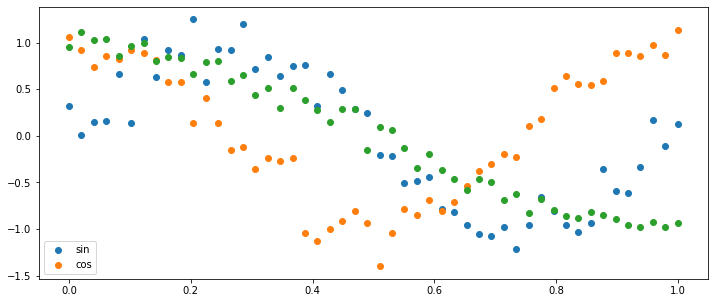

In [5]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
ax.scatter(train_x, train_y[:,0])
ax.scatter(train_x, train_y[:,1])
ax.scatter(train_x, train_y[:,2])
plt.legend(["sin", "cos"])

In [6]:
x = train_x
xx = np.concatenate((x, x, x), axis=0)[:,None]
n = len(x)
idx2 = np.ones(n) + 1
idx = np.concatenate((np.zeros(n), np.ones(n), idx2))[:,None]
X = np.concatenate((xx, idx), axis=1)

y = np.concatenate((train_y[:,0], train_y[:,1], train_y[:,2]))
x.shape, X.shape, y.shape

((50,), (150, 2), (150,))

### Pymc model

In [7]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    # eta = pm.Gamma("eta", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=3, beta=1)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell, active_dims=[0])
    
    W = pm.Normal("W", mu=0, sigma=3, shape=(3,2), testval=np.random.randn(3,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=3)
    coreg = pm.gp.cov.Coregion(input_dim=2, active_dims=[1], kappa=kappa, W=W)
    cov_func = coreg * cov
    
    sigma = pm.HalfNormal("sigma", sigma=3)
    gp = pm.gp.Marginal(cov_func=cov_func)
    y_ = gp.marginal_likelihood("f", X, y, noise=sigma)

/tmp/ipykernel_10045/4103188762.py:7: FutureWarning: The `testval` argument is deprecated; use `initval`.
  W = pm.Normal("W", mu=0, sigma=3, shape=(3,2), testval=np.random.randn(3,2))
/home/danh/WORK/codes/oss/pymc/pymc/gp/cov.py:99: UserWarning: Only 1 column(s) out of 2 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(


In [8]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, W, kappa, sigma]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 95 seconds.


CPU times: user 4min 29s, sys: 8min 1s, total: 12min 31s
Wall time: 1min 42s


In [9]:
x_new = np.linspace(-0.5, 1.5, 200)[:, None]
xx_new = np.concatenate((x_new, x_new, x_new), axis=0)
idx2 = np.ones(200) + 1
idx2 = np.concatenate((np.zeros(200), np.ones(200), idx2))[:, None]
X_new = np.concatenate((xx_new, idx2), axis=1)

In [10]:
X_new.shape

(600, 2)

In [11]:
with model:
    preds = gp.conditional("preds", X_new)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'], random_seed=42)

/home/danh/WORK/codes/oss/pymc/pymc/gp/cov.py:99: UserWarning: Only 1 column(s) out of 2 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(


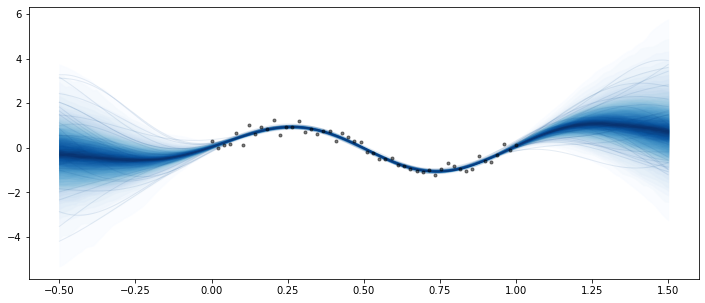

In [12]:
from pymc.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
plot_gp_dist(ax, f_pred[:,:200], X_new[:200,0], palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
ax.plot(x, train_y[:,0], 'ok', ms=3, alpha=0.5, label="Data 1");

(-4.0, 4.0)

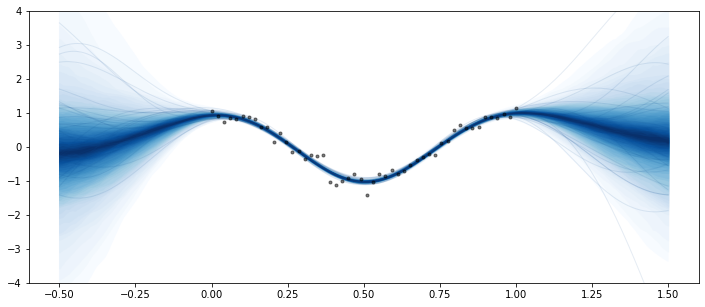

In [13]:
from pymc.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

plot_gp_dist(ax, f_pred[:,200:400], X_new[200:400,0], palette="Blues", fill_alpha=0.9, samples_alpha=0.1)
ax.plot(x, train_y[:,1], 'ok', ms=3, alpha=0.5, label="Data 2");
ax.set_ylim([-4,4])

(-4.0, 4.0)

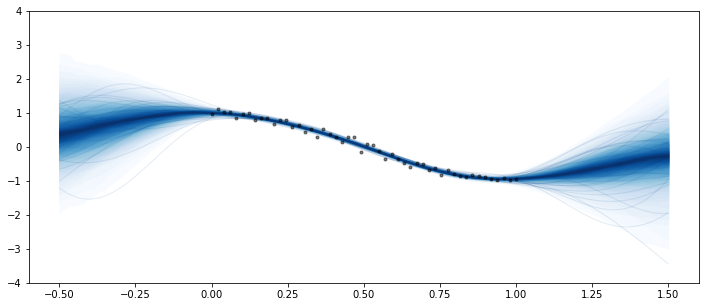

In [14]:
from pymc.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
# plot_gp_dist(ax, f_pred[:,:200], X_new[:200,0], palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
# ax.plot(x, train_y[:,0], 'ok', ms=3, alpha=0.5, label="Data 1");

plot_gp_dist(ax, f_pred[:,400:], X_new[400:,0], palette="Blues", fill_alpha=0.9, samples_alpha=0.1)
ax.plot(x, train_y[:,2], 'ok', ms=3, alpha=0.5, label="Data 2");
ax.set_ylim([-4,4])

In [15]:
az.summary(gp_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"W[0, 0]",-0.071,2.237,-3.973,3.763,0.122,0.100,329.0,288.0,NaN
"W[0, 1]",-0.047,2.131,-3.878,3.815,0.131,0.093,264.0,374.0,NaN
"W[1, 0]",-0.025,2.126,-4.303,3.826,0.114,0.084,346.0,307.0,NaN
"W[1, 1]",0.158,2.238,-4.488,4.388,0.126,0.108,313.0,244.0,NaN
"W[2, 0]",0.106,1.103,-1.927,2.288,0.057,0.059,395.0,219.0,NaN
"W[2, 1]",-0.025,0.913,-1.556,1.820,0.045,0.037,414.0,365.0,NaN
ell,0.335,0.045,0.252,0.415,0.003,0.002,295.0,272.0,NaN
eta,0.689,0.294,0.282,1.342,0.021,0.015,194.0,292.0,NaN
kappa[0],1.822,1.409,0.037,4.241,0.078,0.055,323.0,317.0,NaN
kappa[1],1.738,1.239,0.012,3.955,0.060,0.042,331.0,172.0,NaN


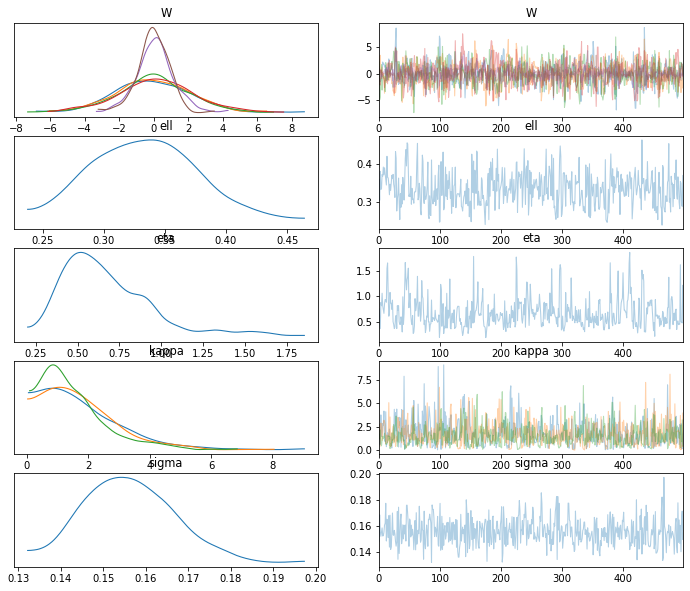

In [16]:
az.plot_trace(gp_trace);

### Sampling with Jax

In [17]:
from pymc.sampling_jax import sample_numpyro_nuts

/home/danh/miniconda3/envs/pymc-dev-py39/lib/python3.9/site-packages/aesara/link/jax/dispatch.py:86: UserWarning: JAX omnistaging couldn't be disabled: Disabling of omnistaging is no longer supported in JAX version 0.2.12 and higher: see https://github.com/google/jax/blob/main/design_notes/omnistaging.md.
  warnings.warn(f"JAX omnistaging couldn't be disabled: {e}")
/home/danh/WORK/codes/oss/pymc/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


In [18]:
%%time
with model:
    jtrace = sample_numpyro_nuts(500, chains=1, target_accept=0.9)

Compiling...


2022-09-04 13:38:14.035603: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Compilation time =  0:00:14.084824
Sampling...


sample: 100%|██████████████████████████████████████████████████████████████████| 1500/1500 [01:22<00:00, 18.14it/s, 1 steps of size 2.23e-308. acc. prob=0.00]


Sampling time =  0:01:28.438783
Transforming variables...
Transformation time =  0:00:00.029051
Computing Log Likelihood...
Log Likelihood time =  0:00:02.799574
CPU times: user 4min 24s, sys: 6min 47s, total: 11min 12s
Wall time: 1min 45s


In [19]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Sep 04 2022

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.3.0

pymc      : 4.1.5
matplotlib: 3.5.2
arviz     : 0.12.1
numpy     : 1.22.4

Watermark: 2.3.0

